In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import sklearn
import sklearn.model_selection
import sklearn.decomposition
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
import scipy
from scipy.sparse.csgraph import laplacian
import numpy as np



In [2]:
# # only ran this once to add the classifications
# ! pip install EcoNameTranslator
# from EcoNameTranslator import classify
# codons = pd.read_csv("codon_usage.csv", low_memory=False)
# # this is how i imported all of the classifications into my csv
# # only need to run once
# for i in range(len(codons)):  # len(codons)
#   name = codons.loc[i, "SpeciesName"]
#   temp = classify([name])[name][1]

#   # filling in the empy columns
#   codons.loc[i, "Domain"] = temp.get("domain")
#   codons.loc[i, "Kingdom"] = temp.get("kingdom")
#   # codons.loc[i, "Phylum"] = temp.get("phylum")
#   codons.loc[i, "Class"] = temp.get("class")
# #   codons.loc[i, "Order"] = temp.get("order")
# #   codons.loc[i, "Family"] = temp.get("family")
# #   codons.loc[i, "Genus"] = temp.get("genus")

# codons.to_csv("classified_codons.csv", index=False)


In [3]:

codons = pd.read_csv("classified_codons.csv", low_memory=False)
genome = codons[codons.DNAtype == 0]
mit = codons[codons.DNAtype == 1]

print(len(genome), len(mit))
print(len(genome) + len(mit))
print(len(codons))

6196 2899
9095
9957


# Exploring Data

9297
9957


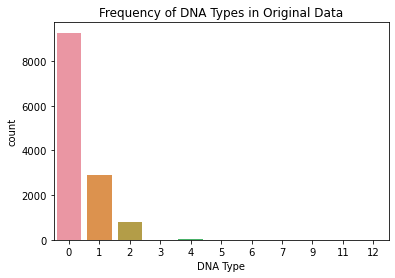

In [4]:
# exploring total data
# print(codons)
print(len(codons.SpeciesID.unique()))  # 9535
print(len(codons.SpeciesID))  # 10195

orig = pd.read_csv("codon_usage.csv", low_memory=False)
used = codons[codons.DNAtype < 2] 
sns.countplot(x=orig.DNAtype)
plt.title("Frequency of DNA Types in Original Data")
plt.xlabel("DNA Type")
plt.show()


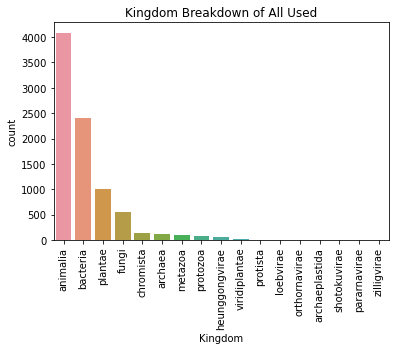

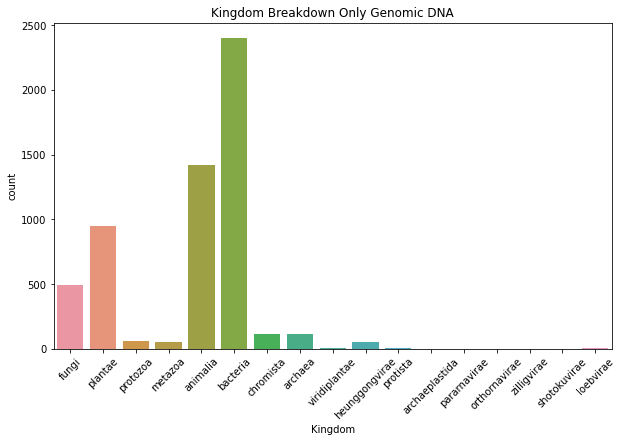

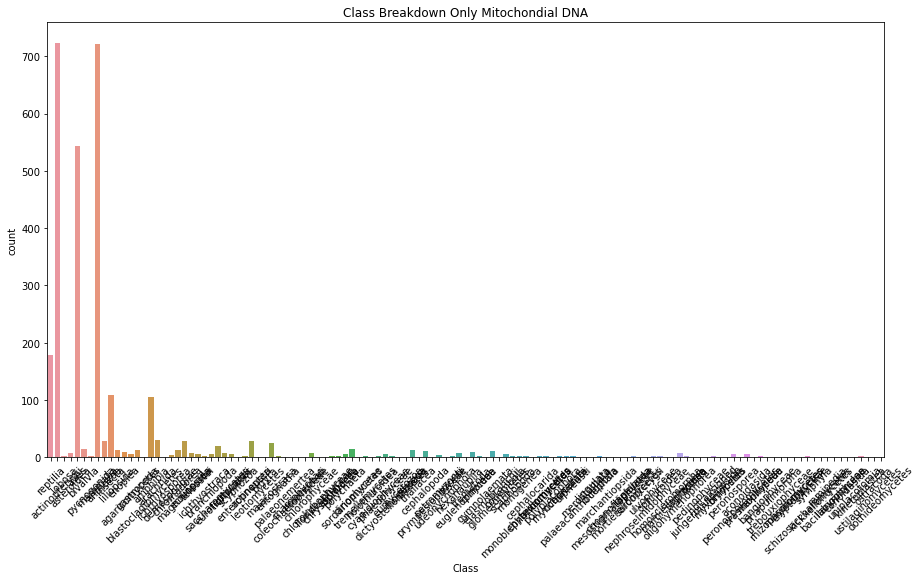

In [30]:
used = codons[codons.DNAtype < 2] 
sns.countplot(x=used.Kingdom, order = used.Kingdom.value_counts().index)
plt.xticks(rotation=90)
plt.title("Kingdom Breakdown of All Used")
plt.show()


# print(len(genome), len(genome.SpeciesID.unique()))
plt.figure(figsize=(10, 6))
sns.countplot(x=genome.Kingdom)
plt.xticks(rotation=45)
plt.title("Kingdom Breakdown Only Genomic DNA")
plt.show()

# print(len(mit), len(mit.SpeciesID.unique()))  # 2899

plt.figure(figsize=(15, 8))
sns.countplot(x=mit.Class)
plt.xticks(rotation=45)
plt.title("Class Breakdown Only Mitochondial DNA")
plt.show()

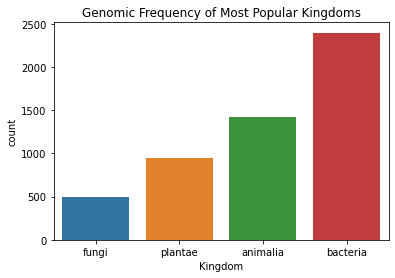

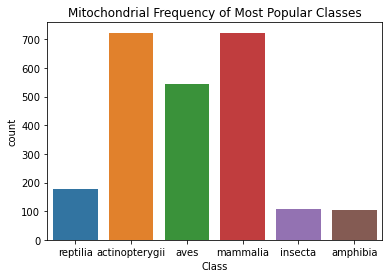

In [6]:
def key_hist(data, dna, tax):
    
    if dna == "Genomic":
        targets = ["animalia", "bacteria", "plantae", "fungi"]
        title = dna + " Frequency of Most Popular " + tax + "s"
    else:
        targets = ["mammalia", "aves", "reptilia", "actinopterygii", "amphibia", "insecta"]       
        title = dna + " Frequency of Most Popular " + tax + "es"
    temp = data[data[tax].isin(targets)]
    sns.countplot(x=temp[tax])
    plt.title(title)
    plt.show()


    
key_hist(genome, "Genomic", "Kingdom")
key_hist(mit, "Mitochondrial", "Class")

In [7]:
# maybe see how many organisms we were able to break down via the econame translator? --> later work

# The Experiments
One of each:
- DNA Type
- Type of data preprocessing (None, NMF)
- Type of clustering (KMeans, spectral)

In [8]:
# Preparing for the experiements

# The first several columns give us information about the organism,
# but are not the codon data we're interested in, so let's split those

genome_orgs = genome.iloc[:, 0:14]
genome_codons = genome.iloc[:, 14:]
mit_orgs = mit.iloc[:, 0:14]
mit_codons = mit.iloc[:, 14:]
genome_results = genome_orgs.copy()
mit_results = mit_orgs.copy()

## NMF

In [9]:
model = sklearn.decomposition.NMF(init="random", random_state=2024, max_iter=5000)  # n_components, init could be none or random im not sure which to use

nmf_genome = model.fit_transform(genome_codons.copy())
nmf_mit = model.fit_transform(mit_codons.copy())
# error in the codons for salmonella, fixing

# got warnings that 200 interations was not enough to reach convergence-- look more into that
# same with 500, though at a certain point maybe it's deminishing returns


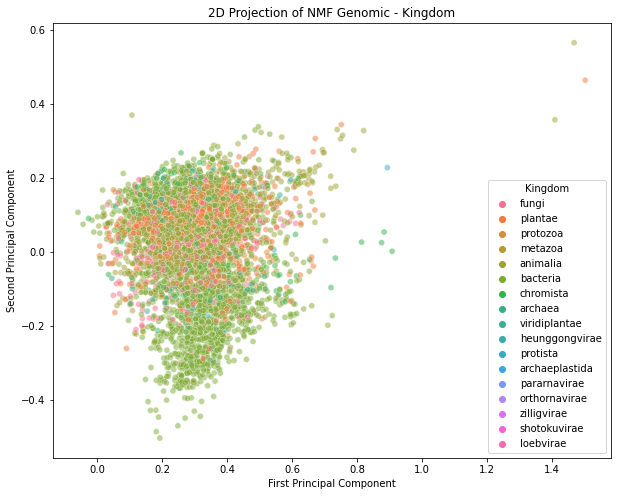

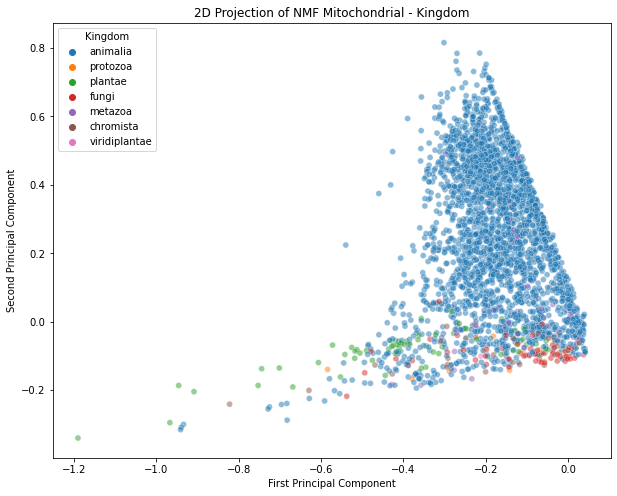

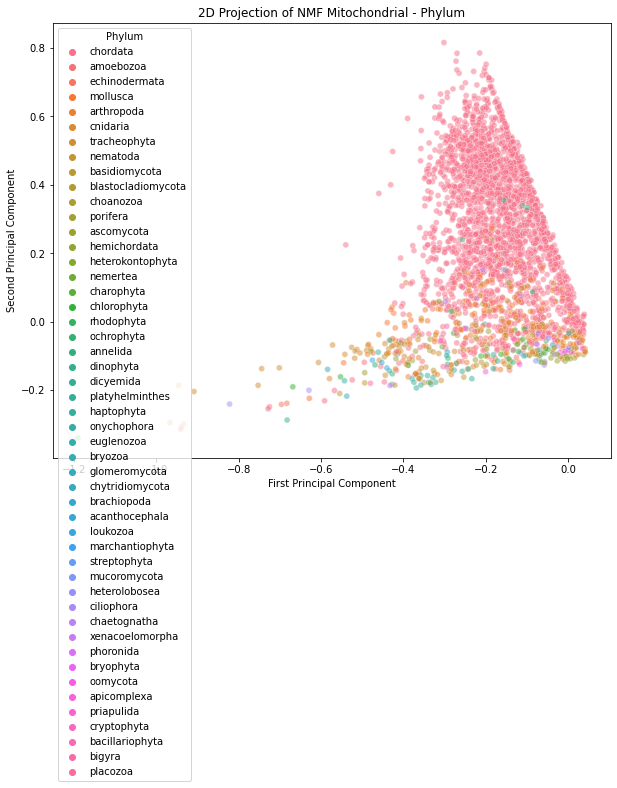

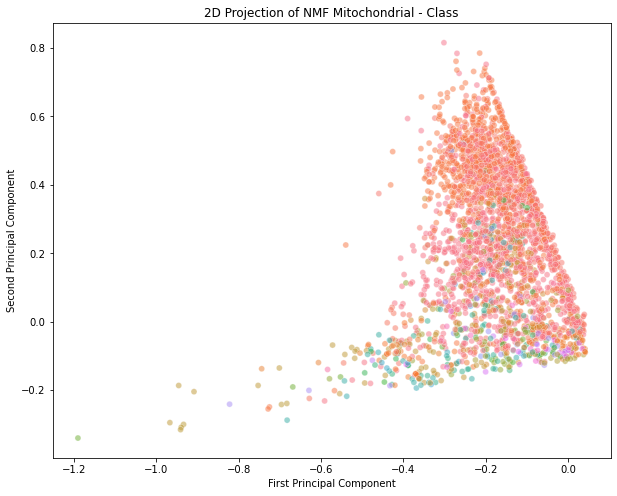

In [10]:
cov = np.cov(nmf_genome.T)
egval, egvec = np.linalg.eig(cov)
biggest_egval = np.argsort(egval)[-2:]  # is this what i'm supposed to be doing?
biggest_egvec = egvec[:, biggest_egval]
proj = np.dot(nmf_genome, biggest_egvec)
temp = genome_orgs.copy()
temp["eig1"] = proj[:, 0]
temp["eig2"] = proj[:, 1]
plt.figure(figsize=(10, 8))
sns.scatterplot(x = temp.eig1, y= temp.eig2, hue=temp.Kingdom, alpha=.5)
# plt.scatter(proj[:, 0], proj[:,1], alpha=.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D Projection of NMF Genomic - Kingdom')
plt.show()

# that's not helpful... we're gunna have to 
# look at more than 2 dimensions, I think
cov = np.cov(nmf_mit.T)
egval, egvec = np.linalg.eig(cov)
biggest_egval = np.argsort(egval)[-2:]
biggest_egvec = egvec[:, biggest_egval]
proj = np.dot(nmf_mit, biggest_egvec)
temp = mit_orgs.copy()
temp["eig1"] = proj[:, 0]
temp["eig2"] = proj[:, 1]
plt.figure(figsize=(10, 8))
sns.scatterplot(x = temp.eig1, y= temp.eig2, hue=temp.Kingdom, alpha=.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D Projection of NMF Mitochondrial - Kingdom')
plt.show()

# change color from kingdom to phylum
plt.figure(figsize=(10, 8))
sns.scatterplot(x = temp.eig1, y= temp.eig2, hue=temp.Phylum, alpha=.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D Projection of NMF Mitochondrial - Phylum')
plt.show()

# change color to class
plt.figure(figsize=(10, 8))
sns.scatterplot(x = temp.eig1, y= temp.eig2, hue=temp.Class, alpha=.5).legend_.remove()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D Projection of NMF Mitochondrial - Class')
plt.show()

# unhelpful
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x = temp.eig1, y= temp.eig2, hue=temp.IsMammal, alpha=.5)  # maybe change this phylum or class?
# plt.xlabel('First Principal Component')
# plt.ylabel('Second Principal Component')
# plt.title('2D Projection of NMF Mitochondrial - Mammals?')
# plt.show()

## KMeans experiments
raw genome kmeans, raw mit kmeans

nmf genome kmeans, nmf mit kmeans

In [11]:
# plotting the inertia to determine number of clusters
def plot_inert(data, ti):
  inert = list()
  for i in range(1, 21):
      model = KMeans(n_clusters=i, random_state=2024)
      model.fit(data)
      inert.append(model.inertia_)

  plt.plot(range(1, 21), inert)
  plt.xticks(range(1, 21))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Inertia")
  to_title = "Inertia Over Number of Clusters -- " + ti
  plt.title(to_title)
  plt.show()

# gives a second metric to pick K from (hopefullly agrees with inertia)
def plot_silh(data):
    silh = list()
    for i in range(2,21):
        model = SpectralClustering(n_clusters=i, random_state=2024)
        labels = model.fit_predict(data)
        silh.append(silhouette_score(data, labels))
    plt.plot(range(2, 21), silh)
    plt.xticks(range(2, 21))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score Over Number of Clusters")
    plt.show()    
        
        

def visualize_kmeans(n, codons, orgs, col):
    model = KMeans(n_clusters=n, random_state=2024) 
    # model.fit(codons)
    labels = model.fit_predict(codons)

    to_vis = orgs.copy()
    to_vis["labels"] = labels
    #to_vis["labels"] = model.labels_

      # sns.countplot(x=raw_genome_kmeans_results.Kingdom, hue=raw_genome_kmeans_results.labels)
      # plt.show()

    for i in range(n):
        temp = to_vis[to_vis.labels == i]
        plt.pie(temp[col].value_counts(), labels=temp[col].value_counts().index)
        title = col + " Breakdown of Cluster " + str(i)
        plt.title(title)
        plt.show()
    
    print("Silhouette Score:", silhouette_score(codons, labels))
    return to_vis


### Raw data KMeans

C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

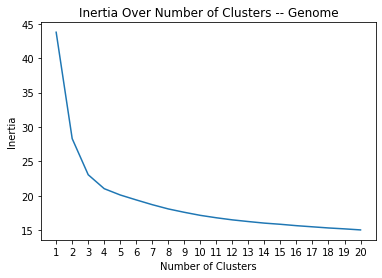

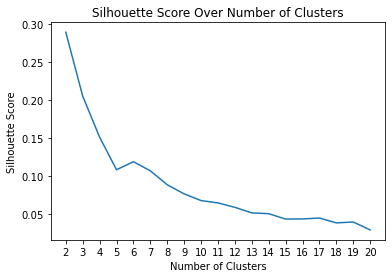

C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


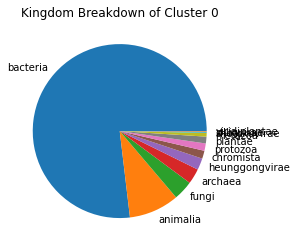

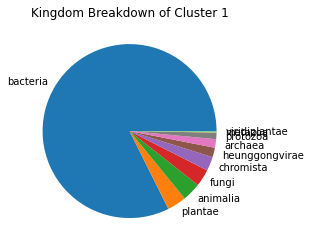

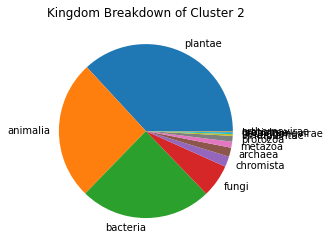

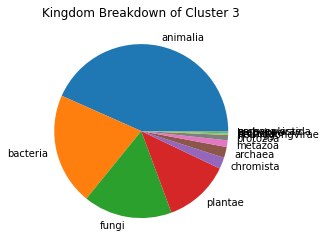

Silhouette Score: 0.17744783911730827


In [12]:
# Kmeans, raw genome
plot_inert(genome_codons, "Genome")
plot_silh(genome_codons)
# 4 looks best to me-- starts looking more linear after that
raw_genome_kmeans = visualize_kmeans(4, genome_codons, genome_orgs, "Kingdom")
genome_results["RawGenomeKmeans"] = raw_genome_kmeans["labels"]
# testing = visualize_kmeans(4, genome_codons, genome_orgs, "Class")
# print(raw_genome_kmeans.head())


In [13]:
# Kmeans, raw mit
# (kingdom ended up not working that well, but class had more promise)
# plot_inert(mit_codons, "Mitochondrial")
# plot_silh(mit_codons)
# # 5??? it's a lot more curved than the last one
# raw_mit_kmeans = visualize_kmeans(5, mit_codons, mit_orgs, "Kingdom")

# print(raw_mit_kmeans.head())


# okay... this one is way biased by the fact that there are way more animals 
# than anything else, so maybe this one shouldn't be kingdom, but instead phylum?

In [14]:
# print(raw_mit_kmeans[raw_mit_kmeans.labels==1].head())
# print("\n\n")
# print(raw_mit_kmeans[raw_mit_kmeans.labels==3].head())

In [15]:
# # so let's try phylum?
# plot_inert(mit_codons, "mitochondrial")
# # 5??? it's a lot more curved than the last one
# raw_mit_kmeans = visualize_kmeans(5, mit_codons, mit_orgs, "Phylum")

# # even that is still rough...

C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

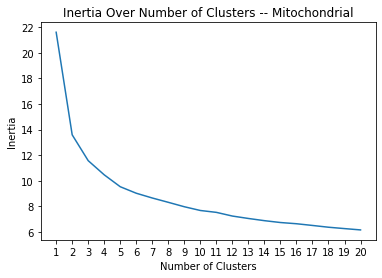

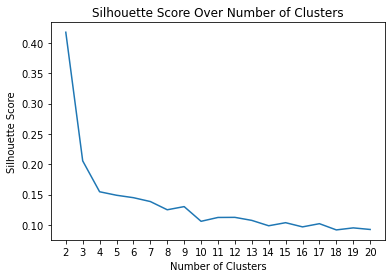

C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


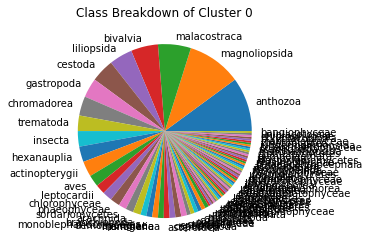

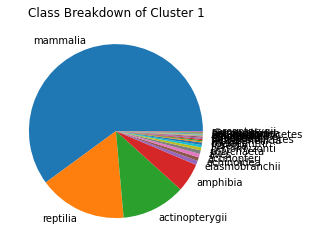

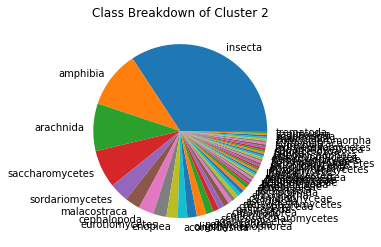

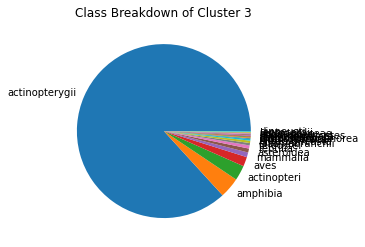

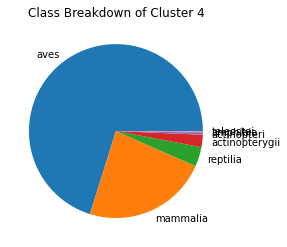

Silhouette Score: 0.19241654074883788


In [16]:
# class
plot_inert(mit_codons, "Mitochondrial")
plot_silh(mit_codons)
# 5??? it's a lot more curved than the last one
raw_mit_kmeans = visualize_kmeans(5, mit_codons, mit_orgs, "Class")

mit_results["RawMitKmeans"] = raw_mit_kmeans["labels"]
# yo!!!!

### KMeans for NMF


C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

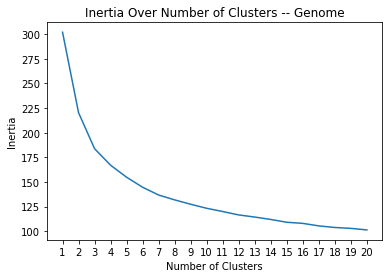

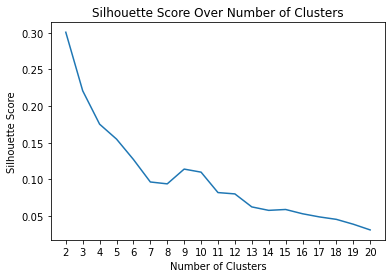

C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


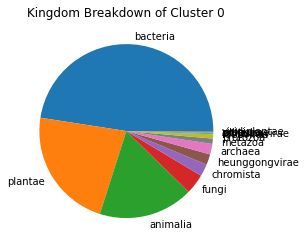

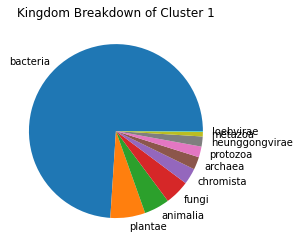

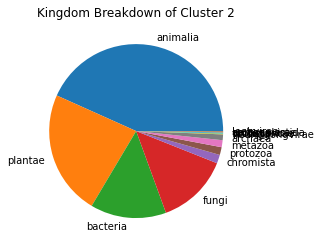

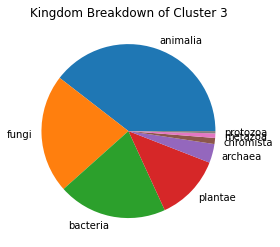

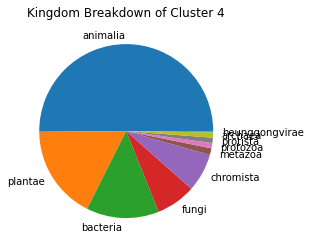

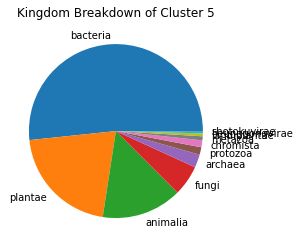

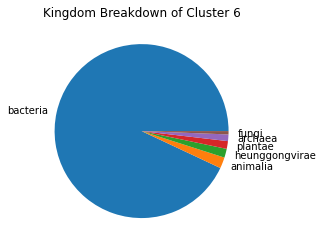

Silhouette Score: 0.14642590083135923


In [17]:
# kmeans nmf genome 
plot_inert(nmf_genome, "Genome")
plot_silh(nmf_genome)
# oh that's hard to tell.... 4? 7?
nmf_genome_kmeans = visualize_kmeans(7, nmf_genome, genome_orgs, "Kingdom")

genome_results["NMFGenomeKmeans"] = nmf_genome_kmeans["labels"]


C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

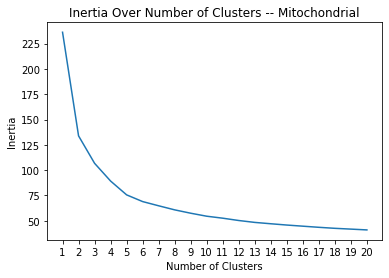

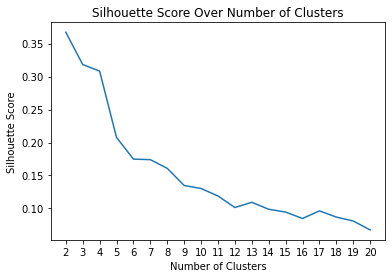

C:\Users\riley\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


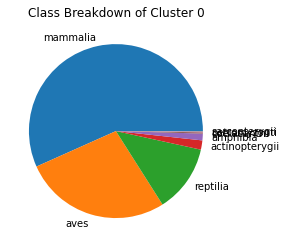

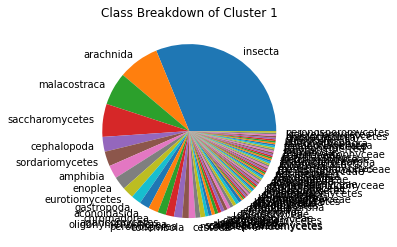

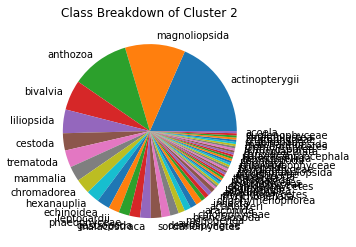

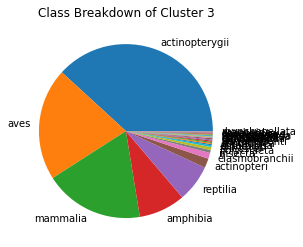

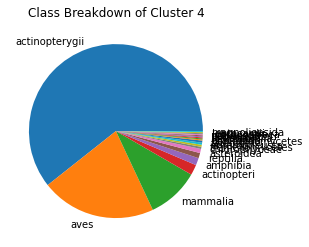

Silhouette Score: 0.2800772976158269


In [18]:
plot_inert(nmf_mit, "Mitochondrial")
plot_silh(nmf_mit)
nmf_mit_kmeans = visualize_kmeans(5, nmf_mit, mit_orgs, "Class")  # or try Phylum or Kingdom
mit_results["NMFMitKmeans"] = nmf_mit_kmeans["labels"]
# cos like the chordata is way over represented...


## Spectral Clustering

In [19]:
# following https://juanitorduz.github.io/spectral_clustering/
# because I think I had a bug

def spectral(data, orgs, col):
    adj = kneighbors_graph(data, 10, mode="connectivity")
    adj = .5 * (adj + adj.T)
    lap = laplacian(adj, normed=False).toarray()
    eva, evc = np.linalg.eig(lap)
    eva = np.real(eva)
    evc = np.real(evc)
    
    eva = eva[np.argsort(eva)]

    mini_ev = eva[0:20] 
    plt.figure(figsize=(15, 8))
    plt.plot(mini_ev, 'o')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue')
    plt.title('Eigenvalues of Laplacian Matrix')
    plt.grid(True)
    plt.show()
    
    print("biggest gap: ", np.argmax(np.diff(mini_ev)) + 1)
    

    plot_silh(data)
    cluster = int(input("How many clusters should there be? "))
    
    model = SpectralClustering(n_clusters=cluster, random_state=2024)
    # screw it, default n_neighbors for the clustering, i might play with it 
    # later, but right now i just want to see if it works
    labels = model.fit_predict(data)
    
    # explore
    to_vis = orgs.copy()
    to_vis["labels"] = labels
    
    for i in range(cluster):
        temp = to_vis[to_vis.labels == i]
        plt.pie(temp[col].value_counts(), labels=temp[col].value_counts().index)
        title = col + " Breakdown of Cluster " + str(i)
        plt.title(title)
        plt.show()
        
    if cluster > 1:
        print("Silhouette Score:", silhouette_score(data, labels))

    return to_vis


### Spectral on Raw Data

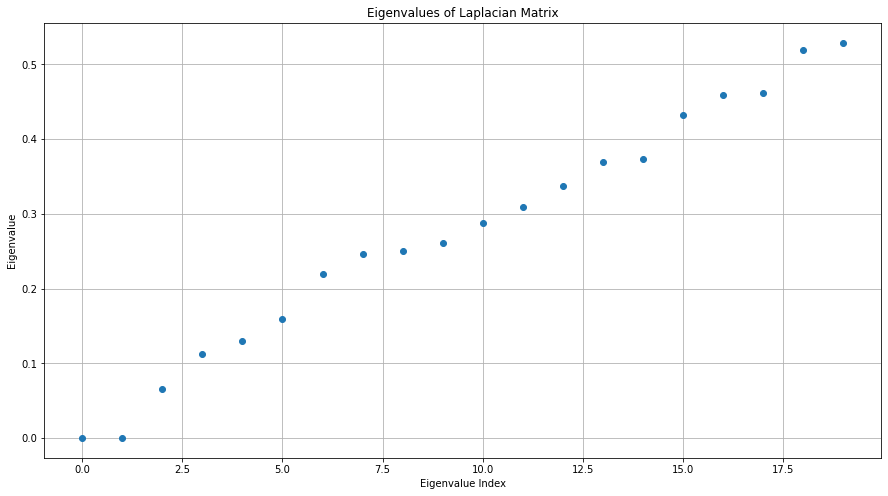

biggest gap:  2


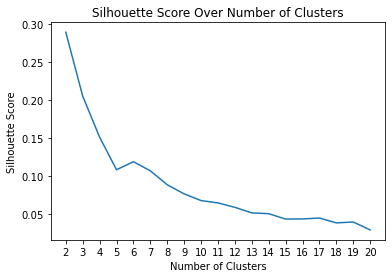

How many clusters should there be? 2


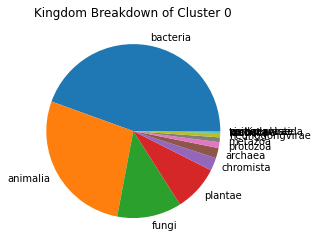

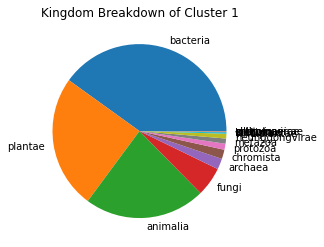

Silhouette Score: 0.2890184201872127
      SpeciesID      Type  IsVertibrate  IsMammal  DNAtype  Ncodons  \
2899     418444     plant             0         0        0     1342   
2900     328805     plant             0         0        0     1286   
2901     413882  bacteria             0         0        0    10966   
2902      45372     plant             0         0        0    20592   
2903      46611     plant             0         0        0    10033   

                                            SpeciesName     Domain  Kingdom  \
2899     Populus tomentosa x P. bolleana x P. tomentosa        NaN      NaN   
2900  Populus tomentosa x P. bolleana x P. tomentosa...        NaN      NaN   
2901                          [Polyangium] brachysporum  eukaryota    fungi   
2902                                         Abies alba  eukaryota  plantae   
2903                                      Abies grandis  eukaryota  plantae   

            Phylum            Class              Order       

In [20]:
raw_genome_spec = spectral(genome_codons, genome_orgs, "Kingdom")  # do 2, clearly 2, for sure
genome_results["RawGenomeSpec"] = raw_genome_spec["labels"]

print(raw_genome_spec.head())

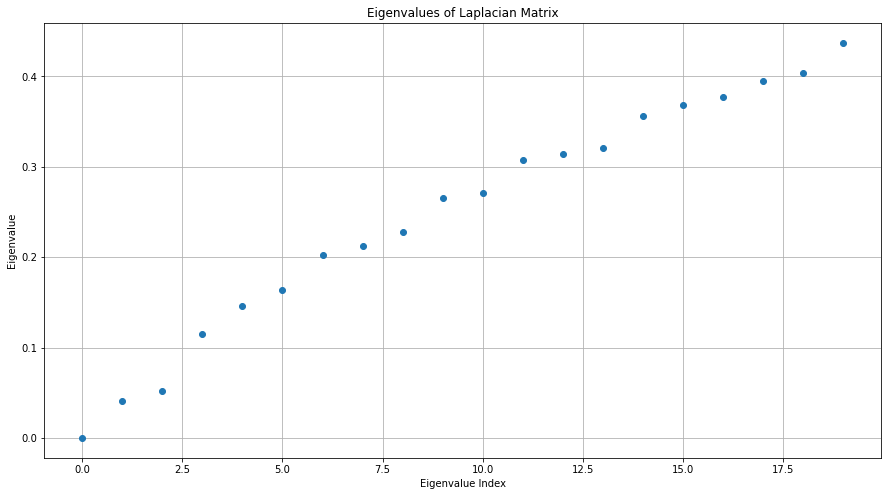

biggest gap:  3


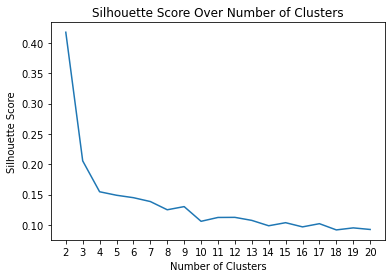

How many clusters should there be? 3


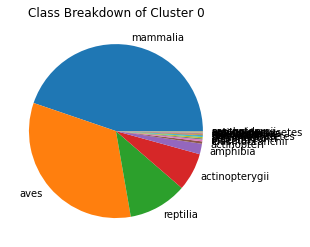

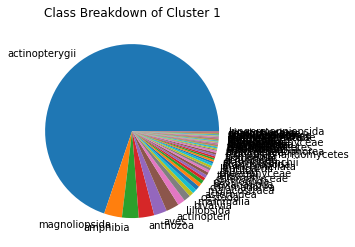

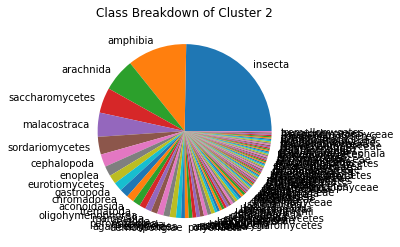

Silhouette Score: 0.20560784450145847
   SpeciesID          Type  IsVertibrate  IsMammal  DNAtype  Ncodons  \
0     278977    vertebrate             1         0        1     2121   
1     192871    vertebrate             1         0        1     2364   
2       5755  invertebrate             0         0        1    11323   
3     339859  invertebrate             0         0        1     2703   
4     133434  invertebrate             0         0        1     2703   

                 SpeciesName     Domain   Kingdom         Phylum  \
0           Abronia graminea  eukaryota  animalia       chordata   
1       Abudefduf vaigiensis  eukaryota  animalia       chordata   
2   Acanthamoeba castellanii  eukaryota  protozoa      amoebozoa   
3    Acanthaster brevispinus  eukaryota  animalia  echinodermata   
4         Acanthaster planci  eukaryota  animalia  echinodermata   

            Class        Order           Family         Genus  labels  
0        reptilia     squamata         anguidae 

In [21]:
raw_mit_spec = spectral(mit_codons, mit_orgs, "Class")  # kingdom, phylum...
mit_results["RawMitSpec"] = raw_mit_spec["labels"] # three clusters

# but 6 gives us more similar breakdowns to kmeans
print(raw_mit_spec.head())

### Spectral for NMF

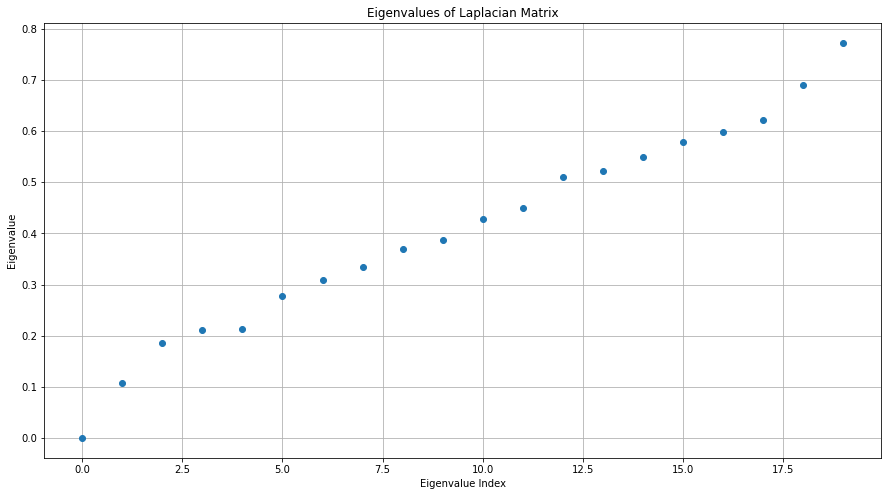

biggest gap:  1


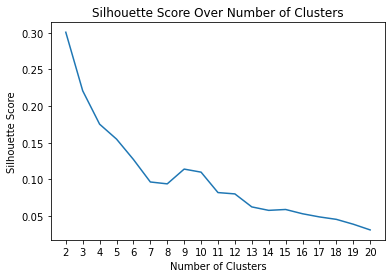

How many clusters should there be? 1


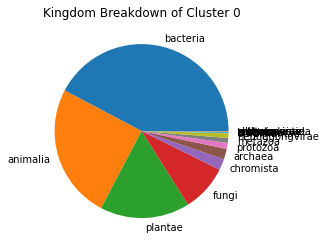

      SpeciesID      Type  IsVertibrate  IsMammal  DNAtype  Ncodons  \
2899     418444     plant             0         0        0     1342   
2900     328805     plant             0         0        0     1286   
2901     413882  bacteria             0         0        0    10966   
2902      45372     plant             0         0        0    20592   
2903      46611     plant             0         0        0    10033   

                                            SpeciesName     Domain  Kingdom  \
2899     Populus tomentosa x P. bolleana x P. tomentosa        NaN      NaN   
2900  Populus tomentosa x P. bolleana x P. tomentosa...        NaN      NaN   
2901                          [Polyangium] brachysporum  eukaryota    fungi   
2902                                         Abies alba  eukaryota  plantae   
2903                                      Abies grandis  eukaryota  plantae   

            Phylum            Class              Order              Family  \
2899           NaN  

In [26]:
nmf_genome_spec = spectral(nmf_genome, genome_orgs, "Kingdom")
genome_results["NMFGenomeSpec"] = nmf_genome_spec["labels"]  # i think its 1
print(nmf_genome_spec.head())

# no actually it just kinda sucks in general -- even 5 clusters is unrevealing


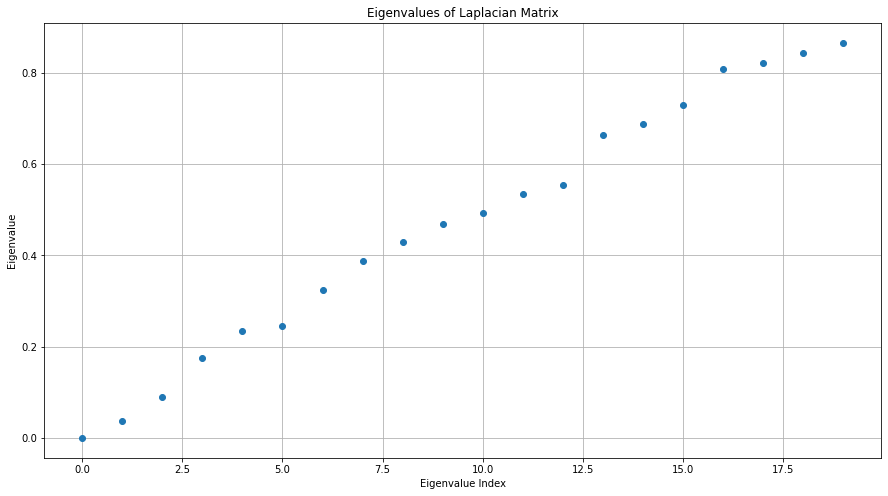

biggest gap:  13


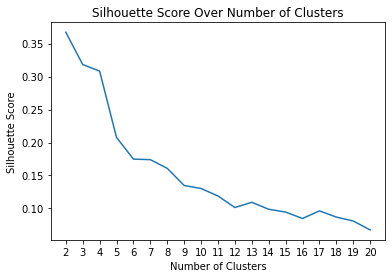

How many clusters should there be? 3


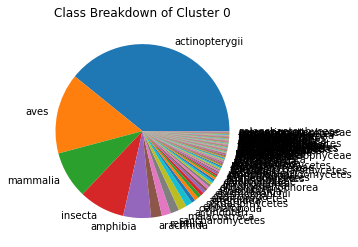

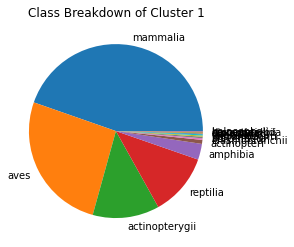

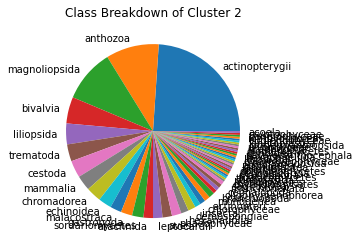

Silhouette Score: 0.31820569713970814


In [23]:
nmf_mit_spec = spectral(nmf_mit, mit_orgs, "Class")
mit_results["NMFMitSpec"] = nmf_mit_spec["labels"]  # 3

# eigengap said 13.... is that too many??? 3 is a smaller gap but is the second largest...
# plotting the score as well

# there's three gaps I'm wondering about here..... I believe 3 is best
# print(nmf_mit_spec.head())

In [24]:
genome_results.to_csv("genome_results.csv", index=False)
mit_results.to_csv("mit_results.csv", index=False)

print(mit_results.head(1))

   SpeciesID        Type  IsVertibrate  IsMammal  DNAtype  Ncodons  \
0     278977  vertebrate             1         0        1     2121   

         SpeciesName     Domain   Kingdom    Phylum     Class     Order  \
0   Abronia graminea  eukaryota  animalia  chordata  reptilia  squamata   

     Family    Genus  RawMitKmeans  NMFMitKmeans  RawMitSpec  NMFMitSpec  
0  anguidae  abronia             1             0           0           1  


# Results
The following pie charts show the Kingdom/ Class makeup of each cluster, as well as the what clusters each Kingdom/ Class ended up in.

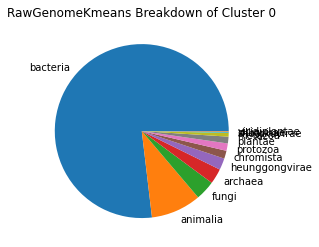

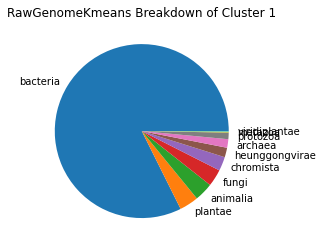

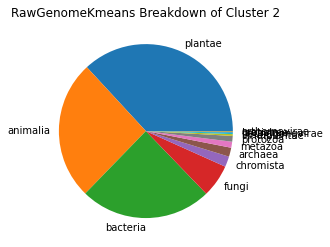

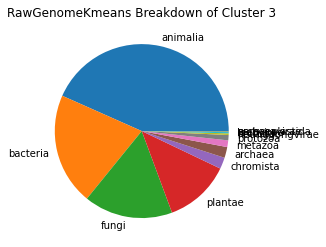

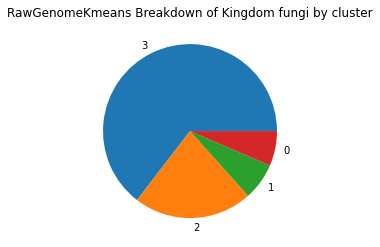

3    319
2    109
1     34
0     32
Name: RawGenomeKmeans, dtype: int64


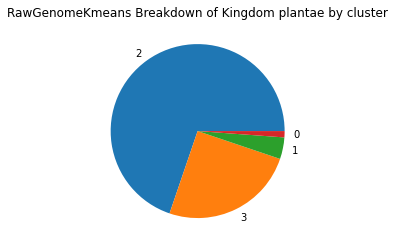

2    660
3    237
1     38
0     11
Name: RawGenomeKmeans, dtype: int64


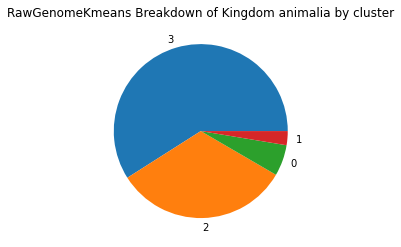

3    838
2    463
0     82
1     37
Name: RawGenomeKmeans, dtype: int64


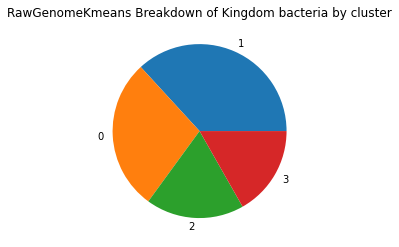

1    883
0    675
2    438
3    402
Name: RawGenomeKmeans, dtype: int64


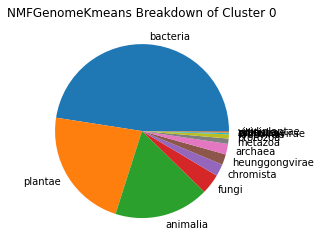

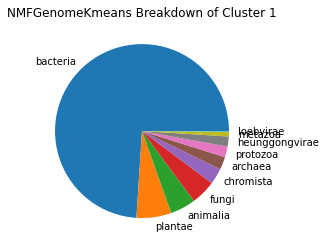

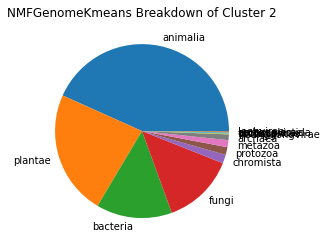

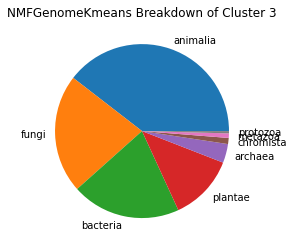

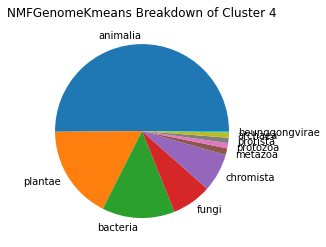

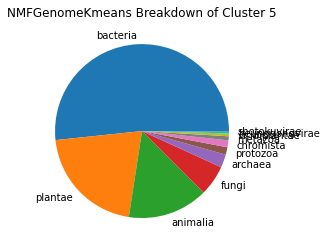

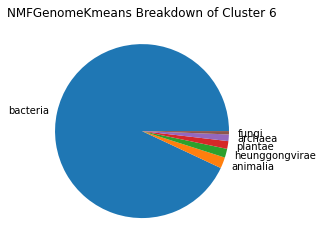

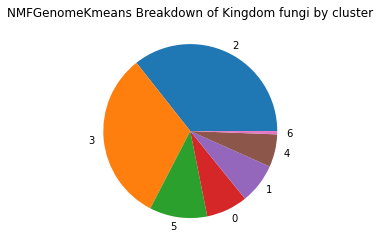

2    176
3    157
5     53
0     38
1     37
4     30
6      3
Name: NMFGenomeKmeans, dtype: int64


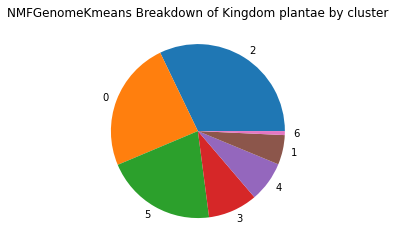

2    304
0    229
5    196
3     87
4     71
1     52
6      7
Name: NMFGenomeKmeans, dtype: int64


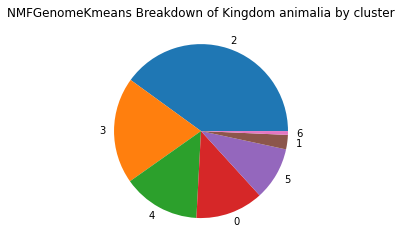

2    568
3    281
4    204
0    179
5    140
1     38
6     10
Name: NMFGenomeKmeans, dtype: int64


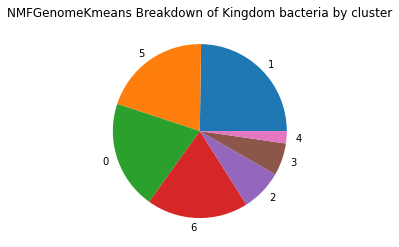

1    594
5    484
0    483
6    453
2    185
3    144
4     55
Name: NMFGenomeKmeans, dtype: int64


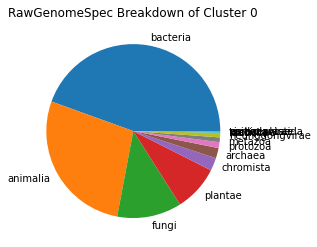

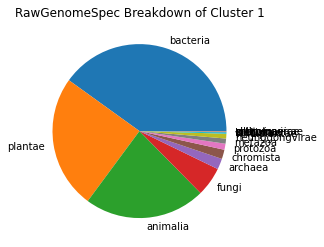

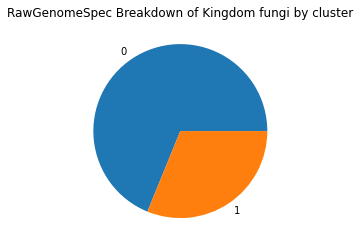

0    340
1    154
Name: RawGenomeSpec, dtype: int64


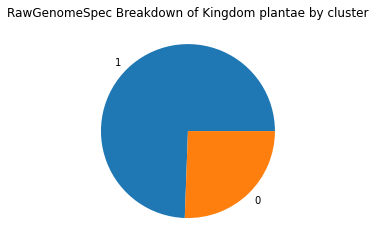

1    704
0    242
Name: RawGenomeSpec, dtype: int64


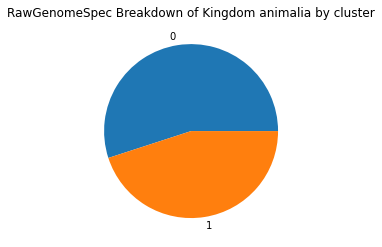

0    781
1    639
Name: RawGenomeSpec, dtype: int64


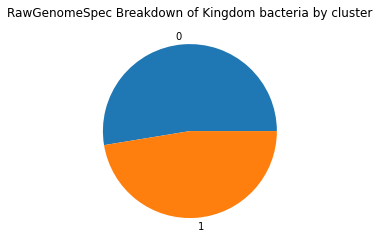

0    1261
1    1137
Name: RawGenomeSpec, dtype: int64


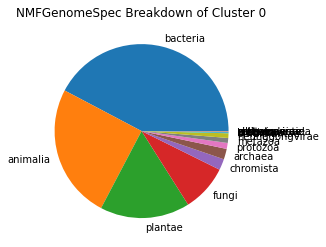

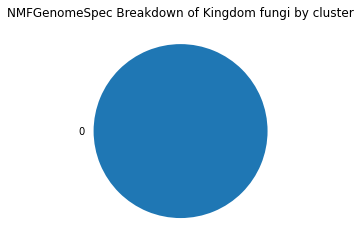

0    494
Name: NMFGenomeSpec, dtype: int64


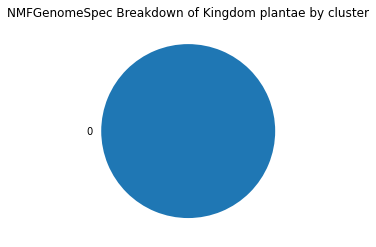

0    946
Name: NMFGenomeSpec, dtype: int64


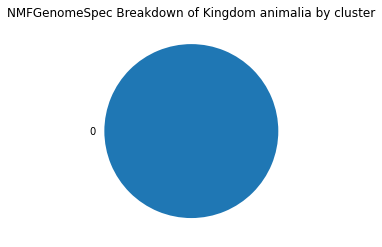

0    1420
Name: NMFGenomeSpec, dtype: int64


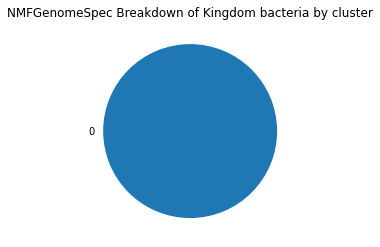

0    2398
Name: NMFGenomeSpec, dtype: int64


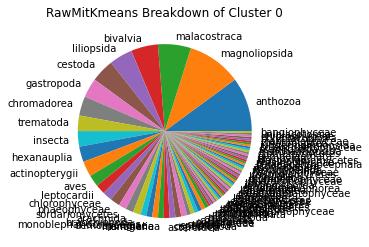

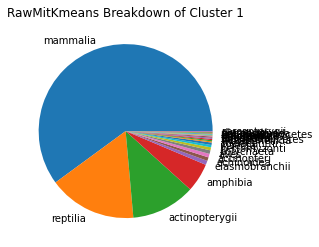

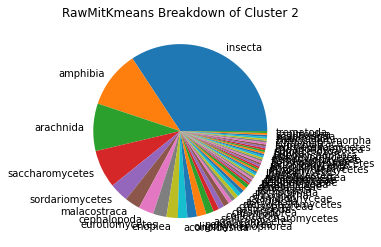

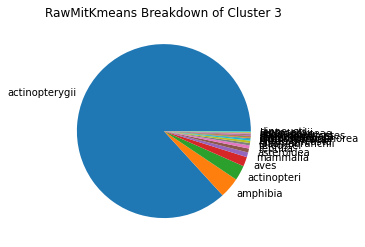

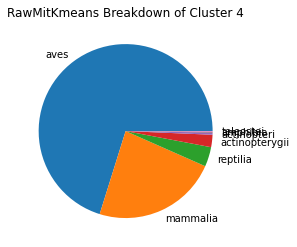

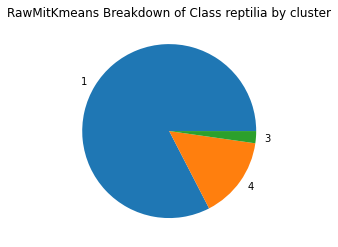

1    147
4     27
3      4
Name: RawMitKmeans, dtype: int64


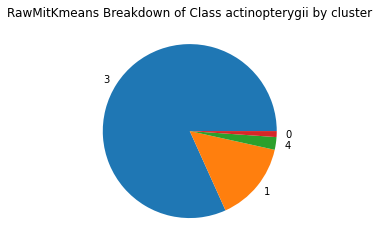

3    591
1    107
4     17
0      8
Name: RawMitKmeans, dtype: int64


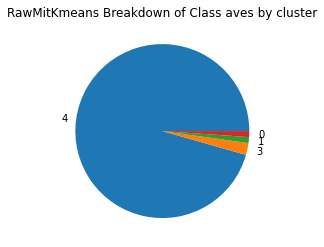

4    520
3     12
1      6
0      6
Name: RawMitKmeans, dtype: int64


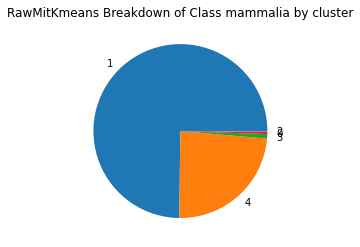

1    540
4    172
3      6
0      3
2      1
Name: RawMitKmeans, dtype: int64


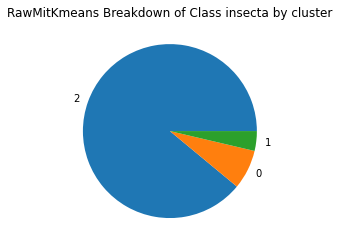

2    97
0     8
1     4
Name: RawMitKmeans, dtype: int64


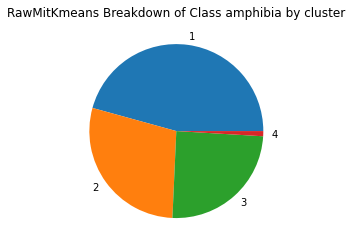

1    48
2    30
3    26
4     1
Name: RawMitKmeans, dtype: int64


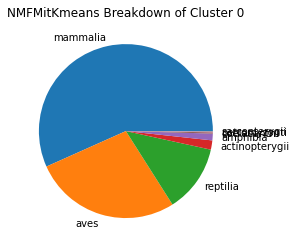

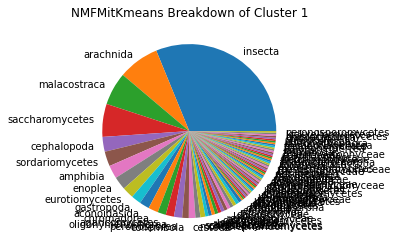

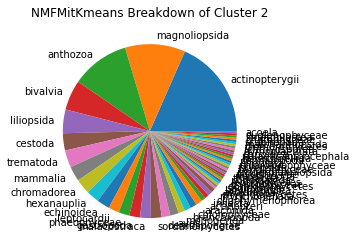

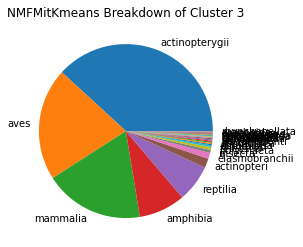

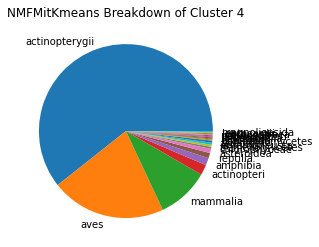

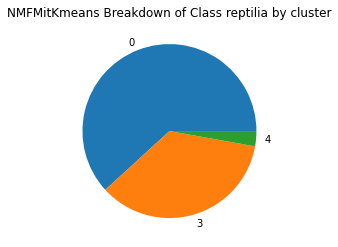

0    110
3     63
4      5
Name: NMFMitKmeans, dtype: int64


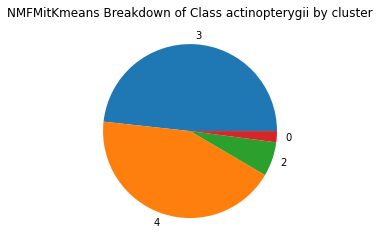

3    349
4    313
2     46
0     15
Name: NMFMitKmeans, dtype: int64


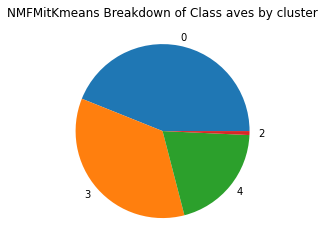

0    239
3    191
4    110
2      4
Name: NMFMitKmeans, dtype: int64


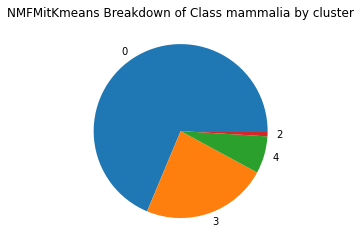

0    496
3    169
4     50
2      7
Name: NMFMitKmeans, dtype: int64


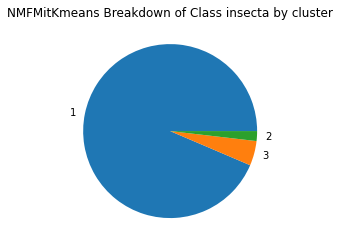

1    102
3      5
2      2
Name: NMFMitKmeans, dtype: int64


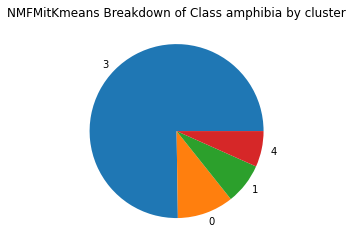

3    79
0    11
1     8
4     7
Name: NMFMitKmeans, dtype: int64


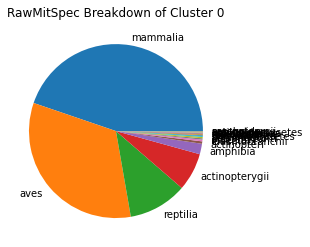

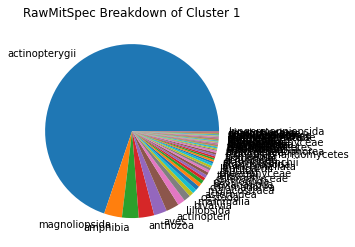

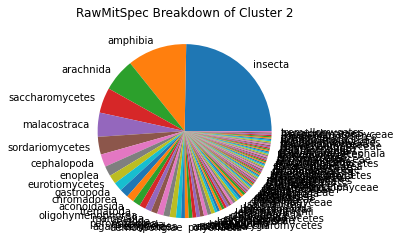

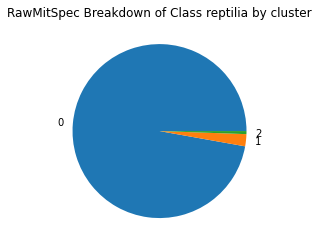

0    173
1      4
2      1
Name: RawMitSpec, dtype: int64


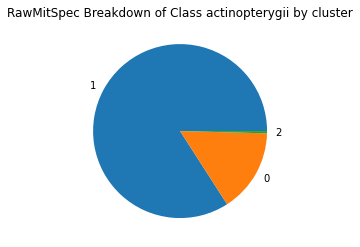

1    608
0    112
2      3
Name: RawMitSpec, dtype: int64


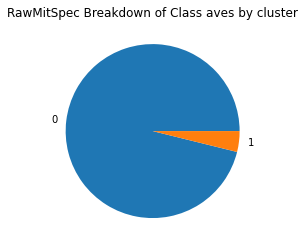

0    523
1     21
Name: RawMitSpec, dtype: int64


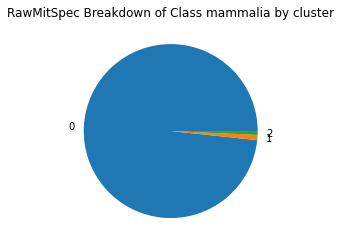

0    710
1      7
2      5
Name: RawMitSpec, dtype: int64


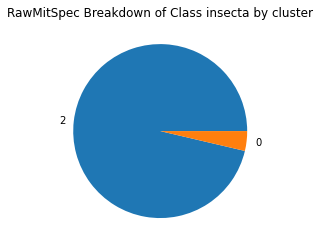

2    105
0      4
Name: RawMitSpec, dtype: int64


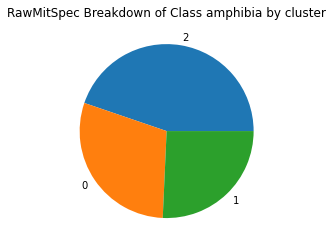

2    47
0    31
1    27
Name: RawMitSpec, dtype: int64


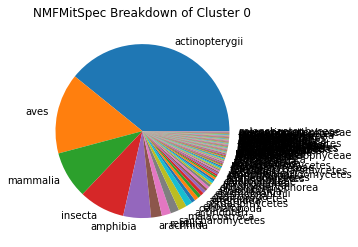

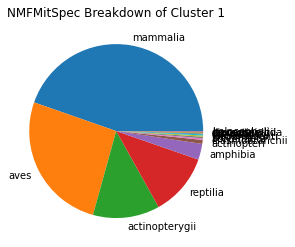

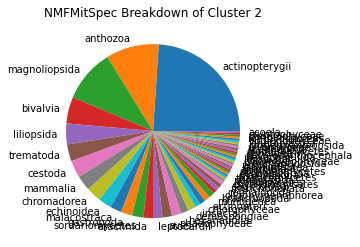

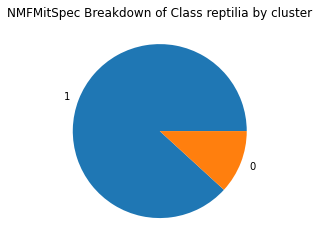

1    157
0     21
Name: NMFMitSpec, dtype: int64


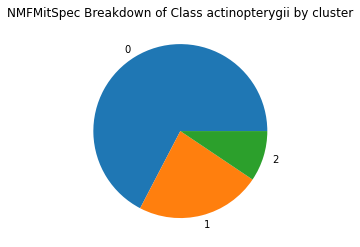

0    487
1    168
2     68
Name: NMFMitSpec, dtype: int64


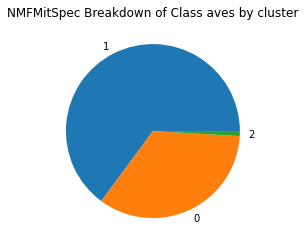

1    353
0    186
2      5
Name: NMFMitSpec, dtype: int64


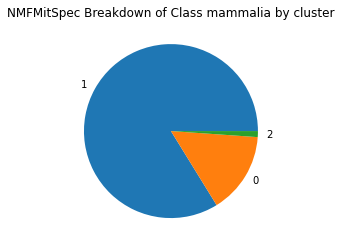

1    605
0    109
2      8
Name: NMFMitSpec, dtype: int64


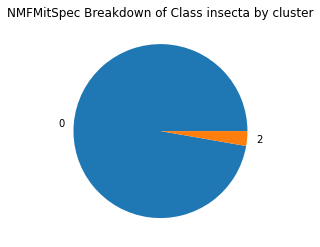

0    106
2      3
Name: NMFMitSpec, dtype: int64


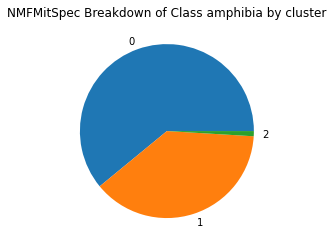

0    64
1    40
2     1
Name: NMFMitSpec, dtype: int64


In [27]:
# uncomment if running at a later date
# genome_results = pd.read_csv("genome_results.csv")
# mit_results = pd.read_csv("mit_results.csv")


def print_results(data, col, tax, dna):
    
    if dna == "genomic":
        targets = ["animalia", "bacteria", "plantae", "fungi"]
    else:
        targets = ["mammalia", "aves", "reptilia", "actinopterygii", "amphibia", "insecta"]       
    
   
    for i in range(0, max(data[col]) + 1):
        temp = data[data[col] == i]
        plt.pie(temp[tax].value_counts(), labels=temp[tax].value_counts().index)
        title = col + " Breakdown of Cluster " + str(i)
        plt.title(title)
        plt.show()
                                        
    for i in data[tax].unique():  # for the organisms
        if i in targets: 
            temp = data[data[tax] == i]
            plt.pie(temp[col].value_counts(), labels=temp[col].value_counts().index)
            title = col + " Breakdown of " + tax + " " + i + " by cluster"
            plt.title(title)
            plt.show()
            print(temp[col].value_counts())

    
g_exp = ["RawGenomeKmeans", "NMFGenomeKmeans",  "RawGenomeSpec", "NMFGenomeSpec"]
m_exp = ["RawMitKmeans", "NMFMitKmeans",  "RawMitSpec", "NMFMitSpec"]

for s in g_exp:
    print_results(genome_results, s, "Kingdom", "genomic")
    
for s in m_exp:
    print_results(mit_results, s, "Class", "mit")


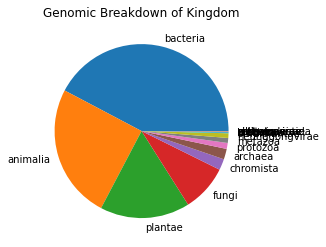

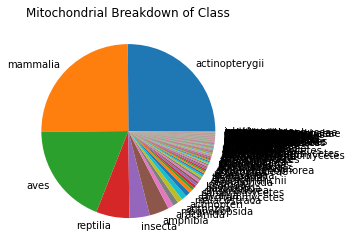

In [29]:
# What would the clusters look like if they were randomly assigned?
plt.pie(genome["Kingdom"].value_counts(), labels=genome["Kingdom"].value_counts().index)
plt.title("Genomic Breakdown of Kingdom")
plt.show()


plt.pie(mit["Class"].value_counts(), labels=mit["Class"].value_counts().index)
plt.title("Mitochondrial Breakdown of Class")
plt.show()


